In [1]:
import models
import math
import numpy as np
import tqdm
import matplotlib.pyplot as plt

plt.rc("text", usetex=True)

In [2]:
def get_boundary_ratios(rho, bounds):
    arrival_rate = 1
    service_rate = 1 / rho
    boundary_ratios = []
    for b in bounds:
        probs = models.get_state_probabilities(
            num_classes=2,
            num_servers=1,
            arrival_rates=[arrival_rate / 2, arrival_rate / 2],
            service_rates=[service_rate, service_rate],
            thetas=[[None, 1], [1, None]],
            bound=b,
        )
        boundary_probs = [probs[s] for s in probs.keys() if (b - 1) in s]
        boundary_ratios.append(sum(boundary_probs) * len(probs) / len(boundary_probs))
    return boundary_ratios

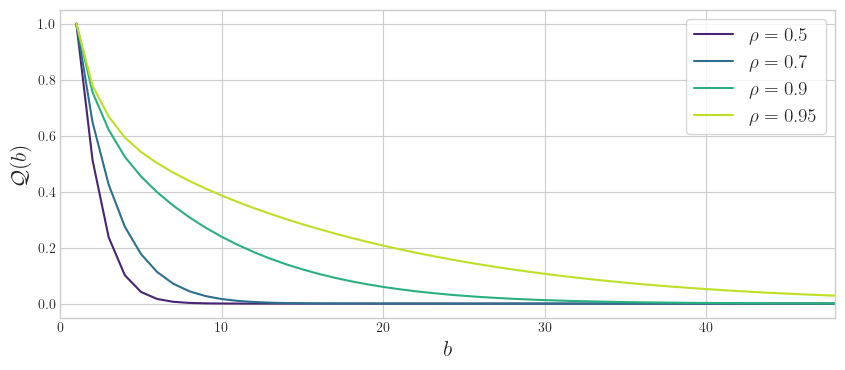

In [3]:
boundary_ratios = {}
rhos = [0.5, 0.7, 0.9, 0.95]
max_bound = 51
bounds = range(1, max_bound)
fig, ax = plt.subplots(1, figsize=(10, 4))
cm = plt.cm.viridis(np.linspace(0.1, 0.9, 4))
for j, rho in enumerate(rhos):
    boundary_ratios[rho] = get_boundary_ratios(rho, bounds)
    ax.plot(bounds, boundary_ratios[rho], label=rf"$\rho = {rho}$", c=cm[j])
r = r"$\mathcal{Q}(b)$"
ax.set_ylabel(r, fontsize=16)
ax.set_xlabel(r"$b$", fontsize=16)
ax.legend(frameon=True, fontsize=14)
ax.set_xlim(0, 48)
fig.savefig("../tex/img/quotient_accuracy.pdf")

In [4]:
def get_probability_of_hitting_boundary(arrival_rates, probs, hitting_probs):
    return sum(
        [
            (arrival_rates[state[-2]] / sum(arrival_rates))
            * probs[state[:-2]]
            * hitting_probs[state]
            for state in list(hitting_probs.keys())[:-1]
            if state[-2] == 0
        ]
    )

In [5]:
def get_prob_hitting_boundary(rho, bounds):
    arrival_rate = 1
    arrival_rates = [arrival_rate / 2, arrival_rate / 2]
    service_rate = 1 / rho
    boundary_hitting_probs = []
    for b in tqdm.tqdm(bounds):
        R = int(b * 0.5)
        (
            statespace,
            transmat,
        ) = models.build_state_space_and_transition_matrix_sojourn_mc(
            num_classes=2,
            num_servers=1,
            arrival_rates=arrival_rates,
            service_rates=[service_rate, service_rate],
            thetas=[[None, 1], [1, None]],
            bound=b,
        )
        probs = models.get_state_probabilities(
            num_classes=2,
            num_servers=1,
            arrival_rates=[arrival_rate / 2, arrival_rate / 2],
            service_rates=[service_rate, service_rate],
            thetas=[[None, 1], [1, None]],
            bound=b,
        )
        boundary_region = [s for s in statespace[:-1] if (b - 1) in s]
        hitting_probs = models.find_hitting_probs(statespace, transmat, boundary_region)
        boundary_hitting_probs.append(
            sum(
                [
                    (arrival_rates[state[-2]] / sum(arrival_rates))
                    * probs[state[:-2]]
                    * hitting_probs[state]
                    for state in list(hitting_probs.keys())[:-1]
                    if state[-2] == 0
                ]
            )
        )
    return boundary_hitting_probs

100%|█████████████████████████████████████████| 25/25 [24:57<00:00, 59.89s/it]


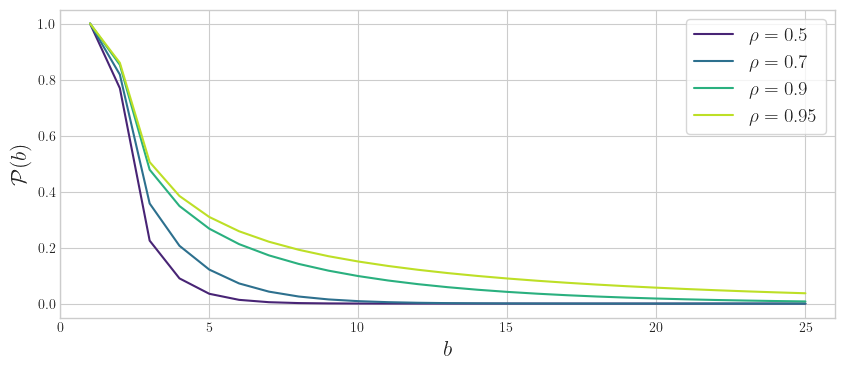

In [6]:
boundary_hitting_probs = {}
rhos = [0.5, 0.7, 0.9, 0.95]
max_bound = 26
bounds = range(1, max_bound)
fig, ax = plt.subplots(1, figsize=(10, 4))
cm = plt.cm.viridis(np.linspace(0.1, 0.9, 4))
for j, rho in enumerate(rhos):
    boundary_hitting_probs[rho] = get_prob_hitting_boundary(rho, bounds)
    ax.plot(bounds, boundary_hitting_probs[rho], label=rf"$\rho = {rho}$", c=cm[j])
r = r"$\mathcal{P}(b)$"
ax.set_ylabel(r, fontsize=16)
ax.set_xlabel(r"$b$", fontsize=16)
ax.legend(frameon=True, fontsize=14)
ax.set_xlim(0, max_bound)
plt.show()
fig.savefig("../tex/img/hitting_accuracy.pdf")

# Compare with Simulation

In [7]:
Q = models.build_and_run_simulation(
    num_classes=2,
    num_servers=1,
    arrival_rates=[2 / 3, 1 / 3],
    service_rates=[3 / 2, 5 / 3],
    class_change_rate_matrix=[[None, 3], [1, None]],
    max_simulation_time=400000,
    progress_bar=True,
)

100%|█████████████████████████████| 400000.0/400000 [00:51<00:00, 7723.42it/s]


In [8]:
state_probs_sim = models.get_state_probabilities_from_simulation(
    Q=Q, warmup=3000, cooldown=3000
)
mean_custs = models.get_average_num_of_customers_from_state_probs(
    state_probs=state_probs_sim, num_classes=2
)
mean_sojourn = models.find_mean_sojourn_time_by_class_from_simulation(
    Q=Q, num_classes=2, warmup=3000
)

In [9]:
mean_custs_mc_by_bound = []
max_bound = 23
bounds = range(1, max_bound)
for b in tqdm.tqdm(bounds):
    probs = models.get_state_probabilities(
        num_classes=2,
        num_servers=1,
        arrival_rates=[2 / 3, 1 / 3],
        service_rates=[3 / 2, 5 / 3],
        thetas=[[None, 3], [1, None]],
        bound=b,
    )
    mean_custs_mc = models.get_average_num_of_customers_from_state_probs(
        state_probs=probs, num_classes=2
    )
    mean_custs_mc_by_bound.append(mean_custs_mc)

100%|█████████████████████████████████████████| 22/22 [00:00<00:00, 91.40it/s]


In [10]:
mean_sojourn_times_mc_by_bound = []
max_bound = 23
bounds = range(1, max_bound)
for b in tqdm.tqdm(bounds):
    probs = models.get_state_probabilities(
        num_classes=2,
        num_servers=1,
        arrival_rates=[2 / 3, 1 / 3],
        service_rates=[3 / 2, 5 / 3],
        thetas=[[None, 3], [1, None]],
        bound=b,
    )
    soj_ss, transmat = models.build_state_space_and_transition_matrix_sojourn_mc(
        num_classes=2,
        num_servers=1,
        arrival_rates=[2 / 3, 1 / 3],
        service_rates=[3 / 2, 5 / 3],
        thetas=[[None, 3], [1, None]],
        bound=b,
    )
    mean_sojourn_times = models.get_mean_sojourn_times(
        state_space_sojourn=soj_ss,
        transition_matrix_sojourn=transmat,
        num_classes=2,
        arrival_rates=[2 / 3, 1 / 3],
        probs=probs,
    )
    mean_sojourn_times_mc_by_bound.append(mean_sojourn_times)

100%|█████████████████████████████████████████| 22/22 [07:16<00:00, 19.83s/it]


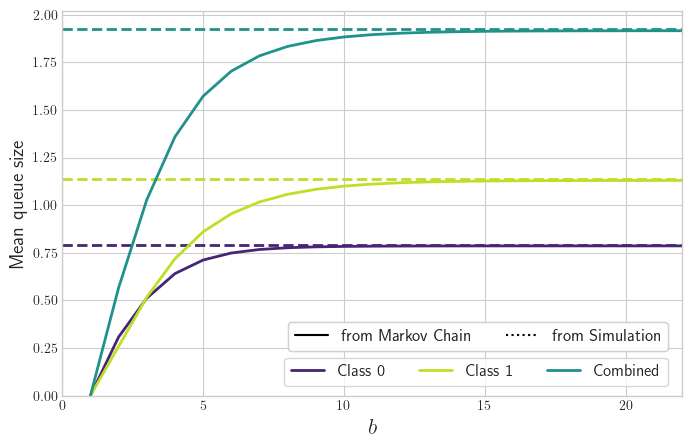

In [11]:
fig, ax = plt.subplots(1, figsize=(8, 5))
cm = plt.cm.viridis(np.linspace(0.1, 0.9, 3))
ax.axhline(mean_custs[0], c=cm[0], linestyle="dashed", linewidth=2)
ax.axhline(mean_custs[1], c=cm[2], linestyle="dashed", linewidth=2)
ax.axhline(mean_custs[-1], c=cm[1], linestyle="dashed", linewidth=2)
(mc_line1,) = ax.plot(
    bounds,
    [m[0] for m in mean_custs_mc_by_bound],
    c=cm[0],
    label="Class 0",
    linewidth=2,
)
(mc_line2,) = ax.plot(
    bounds,
    [m[1] for m in mean_custs_mc_by_bound],
    c=cm[2],
    label="Class 1",
    linewidth=2,
)
(mc_line3,) = ax.plot(
    bounds,
    [m[-1] for m in mean_custs_mc_by_bound],
    c=cm[1],
    label="Combined",
    linewidth=2,
)
(linesim,) = ax.plot([], [], c="black", linestyle="dotted", label="from Simulation")
(linemc,) = ax.plot([], [], c="black", linestyle="solid", label="from Markov Chain")
leg1 = ax.legend(
    handles=[mc_line1, mc_line2, mc_line3],
    ncols=3,
    frameon=True,
    fontsize=12,
    bbox_to_anchor=[0.99, 0.12],
)
leg2 = ax.legend(
    handles=[linemc, linesim],
    frameon=True,
    ncols=2,
    fontsize=12,
    bbox_to_anchor=[0.99, 0.212],
)
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=max_bound - 1)
ax.set_xticks([i * 5 for i in range(5)])
ax.set_ylabel("Mean queue size", fontsize=14)
ax.set_xlabel(r"$b$", fontsize=16)
fig.savefig("../tex/img/queue_size_bound_approaches.pdf")

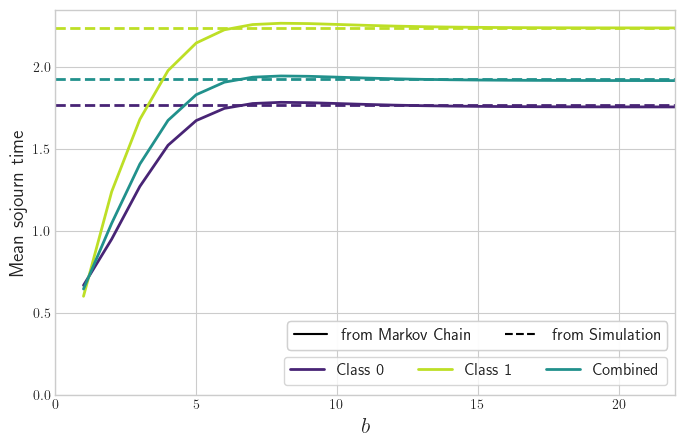

In [12]:
fig, ax = plt.subplots(1, figsize=(8, 5))
cm = plt.cm.viridis(np.linspace(0.1, 0.9, 3))
ax.axhline(mean_sojourn[0], c=cm[0], linestyle="dashed", linewidth=2)
ax.axhline(mean_sojourn[1], c=cm[2], linestyle="dashed", linewidth=2)
ax.axhline(mean_sojourn[-1], c=cm[1], linestyle="dashed", linewidth=2)
(mc_line1,) = ax.plot(
    bounds,
    [m[0] for m in mean_sojourn_times_mc_by_bound],
    c=cm[0],
    label="Class 0",
    linewidth=2,
)
(mc_line2,) = ax.plot(
    bounds,
    [m[1] for m in mean_sojourn_times_mc_by_bound],
    c=cm[2],
    label="Class 1",
    linewidth=2,
)
(mc_line3,) = ax.plot(
    bounds,
    [m[-1] for m in mean_sojourn_times_mc_by_bound],
    c=cm[1],
    label="Combined",
    linewidth=2,
)
(linesim,) = ax.plot([], [], c="black", linestyle="dashed", label="from Simulation")
(linemc,) = ax.plot([], [], c="black", linestyle="solid", label="from Markov Chain")
leg1 = ax.legend(
    handles=[mc_line1, mc_line2, mc_line3],
    ncols=3,
    frameon=True,
    fontsize=12,
    bbox_to_anchor=[1, 0.12],
)
leg2 = ax.legend(
    handles=[linemc, linesim],
    frameon=True,
    ncols=2,
    fontsize=12,
    bbox_to_anchor=[1, 0.212],
)
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=max_bound - 1)
ax.set_xticks([i * 5 for i in range(5)])
ax.set_ylabel("Mean sojourn time", fontsize=14)
ax.set_xlabel(r"$b$", fontsize=16)
fig.savefig("../tex/img/sojourn_time_bound_approaches.pdf")